# Assignment 01: Multi-class Classification 
In this Assignment, you will train a deep model on the CIFAR10 from the scratch using PyTorch.

### Basic Imports

In [51]:
import os
import time
import os.path as osp

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision import transforms
import torchvision

import matplotlib.pyplot as plt
from PIL import Image

import time

### Hyperparameters

In [52]:
# random seed
SEED = 1 
NUM_CLASS = 10

# Training
BATCH_SIZE = 128
NUM_EPOCHS = 50
EVAL_INTERVAL=1
SAVE_DIR = './log'

# Optimizer
LEARNING_RATE = 1e-1
MOMENTUM = 0.9
STEP=5
GAMMA=0.5


### Device

In [53]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#根据系统中是否有可用的CUDA GPU设备来选择设备，并将设备赋值给变量device。如果有可用的CUDA GPU设备，则使用GPU进行加速；否则使用CPU进行运算


### Dataset


In [54]:
# cifar10 transform
transform_cifar10_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),#随机裁剪图像为指定大小（32x32），同时进行填充（padding）操作
    transforms.RandomHorizontalFlip(), #以 0.5 的概率对图像进行随机水平翻转
    transforms.ToTensor(), #将图像转换为张量
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),#对图像进行归一化操作
])

transform_cifar10_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_set = torchvision.datasets.CIFAR10(root='../data', train=True,
                                        download=True, transform=transform_cifar10_train)
#使用 torchvision.datasets.CIFAR10 类创建了一个 CIFAR-10 训练数据集的实例。root 参数指定数据集的存储路径，train=True 表示加载训练数据集，
# download=True 表示如果数据集不存在则自动下载，transform 参数指定了训练数据集的预处理操作。

train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

test_set = torchvision.datasets.CIFAR10(root='../data', train=False,
                                       download=True, transform=transform_cifar10_test)
#使用 torch.utils.data.DataLoader 创建了一个训练数据集的数据加载器。train_set 参数指定了要加载的训练数据集实例，
#batch_size 参数指定了每个批次的样本数量，shuffle=True 表示每个轮次随机打乱数据集的顺序，num_workers 参数指定了加载数据的并行工作线程数量。

test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Files already downloaded and verified
Files already downloaded and verified


### Model

In [55]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 4, 3)  
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(4, 8, 3)  
        self.fc1 = nn.Linear(8 * 6 * 6, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 8 * 6 * 6)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [56]:
model = ConvNet()
model.to(device)

ConvNet(
  (conv1): Conv2d(3, 4, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=288, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=10, bias=True)
)

### Optimizer

In [57]:
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)

### Task 1: per batch training/testing
---

Please denfine two function named ``train_batch`` and ``test_batch``. These functions are essential for training and evaluating machine learning models using batched data from dataloaders.

**To do**: 
1. Define the loss function i.e [nn.CrossEntropyLoss()](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html).
2. Take the image as the input and generate the output using the pre-defined SimpleNet.
3. Calculate the loss between the output and the corresponding label using the loss function.

In [58]:
##################### Write your answer here ##################
# Define the loss function
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        ce_loss = nn.CrossEntropyLoss(reduction='none')(inputs, targets)
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        return focal_loss.mean()
criterion = nn.L1Loss()
# criterion = nn.CrossEntropyLoss()
# criterion = FocalLoss(alpha=0.25, gamma=2)
###############################################################

In [59]:
def train_batch(model, image, target):
    """
    Perform one training batch iteration.

    Args:
        model (torch.nn.Module): The machine learning model to train.
        image (torch.Tensor): Batch of input data (images).
        target (torch.Tensor): Batch of target labels.

    Returns:
        torch.Tensor: Model output (predictions) for the batch.
        torch.Tensor: Loss value calculated by the defined loss function loss_fn().
    """
    
    ##################### Write your answer here ##################
    output = model(image)
    loss = criterion(F.softmax(output,dim = 1), F.one_hot(target,num_classes=10))
    ###############################################################

    return output, loss

In [60]:

def test_batch(model, image, target):
    """
    Perform one testing batch iteration.

    Args:
        model (torch.nn.Module): The machine learning model to evaluate.
        image (torch.Tensor): Batch of input data (images).
        target (torch.Tensor): Batch of target labels.

    Returns:
        torch.Tensor: Model output (predictions) for the batch.
        torch.Tensor: Loss value calculated for the batch.
    """

    ##################### Write your answer here ##################
    output = model(image)
    loss = criterion(F.softmax(output,dim = 1), F.one_hot(target,num_classes=10))
    ###############################################################

    return output, loss

### Model Trainingcriterion

In [61]:
training_acc_m = []
testing_acc_m = []

start_time = time.time()
converged = False
prev_loss = float('inf')# 初始损失设置为正无穷大
end_epoch_m = NUM_EPOCHS

for epoch in range(NUM_EPOCHS):
    model.train()
    torch.cuda.empty_cache()

    ##########################
    ### Training
    ##########################

    running_cls_loss = 0.0
    running_cls_corrects = 0

    for batch_idx, (image, target) in enumerate(train_dataloader):

        image = image.to(device)
        target = target.to(device)

        # train model
        outputs, loss = train_batch(model, image, target)
        _, preds = torch.max(outputs, 1)

        loss_data = loss.data.item()
        if np.isnan(loss_data):
            raise ValueError('loss is nan while training')
        running_cls_loss += loss.item()
        running_cls_corrects += torch.sum(preds == target.data)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    epoch_loss = running_cls_loss / len(train_set)
    epoch_acc = running_cls_corrects.double() / len(train_set)

    print(f'Epoch: {epoch+1}/{NUM_EPOCHS} Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    training_acc_m.append(epoch_acc.cpu().detach().numpy())

    

    # change learning rate
    scheduler.step()


##########################
### Testing
##########################
# # eval model during training or in the last epoch
    if (epoch + 1) % EVAL_INTERVAL == 0 or (epoch + 1) == NUM_EPOCHS:
        print('Begin test......')
        model.eval()

        val_loss = 0.0
        val_corrects = 0

        for batch_idx, (image, target) in enumerate(test_dataloader):

            image = image.to(device)
            target = target.to(device)

            # test model
            outputs, loss = test_batch(model, image, target)
            _, preds = torch.max(outputs, 1)

            val_loss += loss.item()
            val_corrects += torch.sum(preds == target.data)

        val_loss = val_loss / len(test_set)
        val_acc = val_corrects.double() / len(test_set)
        print(f'Test Loss: {val_loss:.4f} Acc: {val_acc:.4f}')

        testing_acc_m.append(val_acc.cpu().detach().numpy())

    # save the model in the last epoch
    if (epoch + 1) == NUM_EPOCHS:
        state = {
            'state_dict': model.state_dict(),
            'acc': epoch_acc,
            'epoch': (epoch + 1),
        }

        # check the dir
        if not os.path.exists(SAVE_DIR):
            os.makedirs(SAVE_DIR)

        # save the state
        torch.save(state, os.path.join(SAVE_DIR, 'checkpoint_%s.pth' % (str(epoch + 1))))
    if epoch > 35 and abs(epoch_loss - prev_loss) < 7e-6:
        converged = True
        break

    prev_loss = epoch_loss
    
end_time = time.time()
convergence_time_m = end_time - start_time
if converged:
    print("Model converged.")
    print(f"Convergence time: {convergence_time_m:.2f} seconds")
    end_epoch_m = epoch +1
    print(f"Convergence epoch: {end_epoch_m:.2f}")
else:
    print("Model did not converge within the specified number of epochs.")
    
    
##############################################################################################################################################
def train_batch(model, image, target):
    output = model(image)
    loss = criterion(output, target)
    return output, loss
def test_batch(model, image, target):
    output = model(image)
    loss = criterion(output,target)
    return output, loss

criterion = nn.CrossEntropyLoss()
model = ConvNet()
model.to(device)
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)

training_acc_c = []
testing_acc_c = []

start_time = time.time()
converged = False
prev_loss = float('inf')# 初始损失设置为正无穷大
end_epoch_c = NUM_EPOCHS

for epoch in range(NUM_EPOCHS):
    model.train()
    torch.cuda.empty_cache()

    ##########################
    ### Training
    ##########################

    running_cls_loss = 0.0
    running_cls_corrects = 0

    for batch_idx, (image, target) in enumerate(train_dataloader):

        image = image.to(device)
        target = target.to(device)

        # train model
        outputs, loss = train_batch(model, image, target)
        _, preds = torch.max(outputs, 1)

        loss_data = loss.data.item()
        if np.isnan(loss_data):
            raise ValueError('loss is nan while training')
        running_cls_loss += loss.item()
        running_cls_corrects += torch.sum(preds == target.data)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    epoch_loss = running_cls_loss / len(train_set)
    epoch_acc = running_cls_corrects.double() / len(train_set)

    print(f'Epoch: {epoch+1}/{NUM_EPOCHS} Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    training_acc_c.append(epoch_acc.cpu().detach().numpy())

    

    # change learning rate
    scheduler.step()


##########################
### Testing
##########################
# # eval model during training or in the last epoch
    if (epoch + 1) % EVAL_INTERVAL == 0 or (epoch + 1) == NUM_EPOCHS:
        print('Begin test......')
        model.eval()

        val_loss = 0.0
        val_corrects = 0

        for batch_idx, (image, target) in enumerate(test_dataloader):

            image = image.to(device)
            target = target.to(device)

            # test model
            outputs, loss = test_batch(model, image, target)
            _, preds = torch.max(outputs, 1)

            val_loss += loss.item()
            val_corrects += torch.sum(preds == target.data)

        val_loss = val_loss / len(test_set)
        val_acc = val_corrects.double() / len(test_set)
        print(f'Test Loss: {val_loss:.4f} Acc: {val_acc:.4f}')

        testing_acc_c.append(val_acc.cpu().detach().numpy())

    # save the model in the last epoch
    if (epoch + 1) == NUM_EPOCHS:
        state = {
            'state_dict': model.state_dict(),
            'acc': epoch_acc,
            'epoch': (epoch + 1),
        }

        # check the dir
        if not os.path.exists(SAVE_DIR):
            os.makedirs(SAVE_DIR)

        # save the state
        torch.save(state, os.path.join(SAVE_DIR, 'checkpoint_%s.pth' % (str(epoch + 1))))
    if epoch > 35 and abs(epoch_loss - prev_loss) < 7e-6:
        converged = True
        break

    prev_loss = epoch_loss
    
end_time = time.time()
convergence_time_c = end_time - start_time
if converged:
    print("Model converged.")
    print(f"Convergence time: {convergence_time_c:.2f} seconds")
    end_epoch_c = epoch +1
    print(f"Convergence epoch: {end_epoch_c:.2f}")
else:
    print("Model did not converge within the specified number of epochs.")

##############################################################################################################################################
criterion = criterion = FocalLoss(alpha=0.25, gamma=2)
model = ConvNet()
model.to(device)
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)

training_acc_f2 = []
testing_acc_f2 = []

start_time = time.time()
converged = False
prev_loss = float('inf')# 初始损失设置为正无穷大
end_epoch_f2 = NUM_EPOCHS

for epoch in range(NUM_EPOCHS):
    model.train()
    torch.cuda.empty_cache()

    ##########################
    ### Training
    ##########################

    running_cls_loss = 0.0
    running_cls_corrects = 0

    for batch_idx, (image, target) in enumerate(train_dataloader):

        image = image.to(device)
        target = target.to(device)

        # train model
        outputs, loss = train_batch(model, image, target)
        _, preds = torch.max(outputs, 1)

        loss_data = loss.data.item()
        if np.isnan(loss_data):
            raise ValueError('loss is nan while training')
        running_cls_loss += loss.item()
        running_cls_corrects += torch.sum(preds == target.data)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    epoch_loss = running_cls_loss / len(train_set)
    epoch_acc = running_cls_corrects.double() / len(train_set)

    print(f'Epoch: {epoch+1}/{NUM_EPOCHS} Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    training_acc_f2.append(epoch_acc.cpu().detach().numpy())

    

    # change learning rate
    scheduler.step()


##########################
### Testing
##########################
# # eval model during training or in the last epoch
    if (epoch + 1) % EVAL_INTERVAL == 0 or (epoch + 1) == NUM_EPOCHS:
        print('Begin test......')
        model.eval()

        val_loss = 0.0
        val_corrects = 0

        for batch_idx, (image, target) in enumerate(test_dataloader):

            image = image.to(device)
            target = target.to(device)

            # test model
            outputs, loss = test_batch(model, image, target)
            _, preds = torch.max(outputs, 1)

            val_loss += loss.item()
            val_corrects += torch.sum(preds == target.data)

        val_loss = val_loss / len(test_set)
        val_acc = val_corrects.double() / len(test_set)
        print(f'Test Loss: {val_loss:.4f} Acc: {val_acc:.4f}')

        testing_acc_f2.append(val_acc.cpu().detach().numpy())

    # save the model in the last epoch
    if (epoch + 1) == NUM_EPOCHS:
        state = {
            'state_dict': model.state_dict(),
            'acc': epoch_acc,
            'epoch': (epoch + 1),
        }

        # check the dir
        if not os.path.exists(SAVE_DIR):
            os.makedirs(SAVE_DIR)

        # save the state
        torch.save(state, os.path.join(SAVE_DIR, 'checkpoint_%s.pth' % (str(epoch + 1))))
    if epoch > 35 and abs(epoch_loss - prev_loss) < 7e-6:
        converged = True
        break

    prev_loss = epoch_loss
    
end_time = time.time()
convergence_time_f2 = end_time - start_time
if converged:
    print("Model converged.")
    print(f"Convergence time: {convergence_time_f2:.2f} seconds")
    end_epoch_f2 = epoch +1
    print(f"Convergence epoch: {end_epoch_f2:.2f}")
else:
    print("Model did not converge within the specified number of epochs.")
    
##############################################################################################################################################
criterion = criterion = FocalLoss(alpha=0.25, gamma=0.5)
model = ConvNet()
model.to(device)
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)

training_acc_f5 = []
testing_acc_f5 = []

start_time = time.time()
converged = False
prev_loss = float('inf')# 初始损失设置为正无穷大
end_epoch_f5 = NUM_EPOCHS

for epoch in range(NUM_EPOCHS):
    model.train()
    torch.cuda.empty_cache()

    ##########################
    ### Training
    ##########################

    running_cls_loss = 0.0
    running_cls_corrects = 0

    for batch_idx, (image, target) in enumerate(train_dataloader):

        image = image.to(device)
        target = target.to(device)

        # train model
        outputs, loss = train_batch(model, image, target)
        _, preds = torch.max(outputs, 1)

        loss_data = loss.data.item()
        if np.isnan(loss_data):
            raise ValueError('loss is nan while training')
        running_cls_loss += loss.item()
        running_cls_corrects += torch.sum(preds == target.data)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    epoch_loss = running_cls_loss / len(train_set)
    epoch_acc = running_cls_corrects.double() / len(train_set)

    print(f'Epoch: {epoch+1}/{NUM_EPOCHS} Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    training_acc_f5.append(epoch_acc.cpu().detach().numpy())

    

    # change learning rate
    scheduler.step()


##########################
### Testing
##########################
# # eval model during training or in the last epoch
    if (epoch + 1) % EVAL_INTERVAL == 0 or (epoch + 1) == NUM_EPOCHS:
        print('Begin test......')
        model.eval()

        val_loss = 0.0
        val_corrects = 0

        for batch_idx, (image, target) in enumerate(test_dataloader):

            image = image.to(device)
            target = target.to(device)

            # test model
            outputs, loss = test_batch(model, image, target)
            _, preds = torch.max(outputs, 1)

            val_loss += loss.item()
            val_corrects += torch.sum(preds == target.data)

        val_loss = val_loss / len(test_set)
        val_acc = val_corrects.double() / len(test_set)
        print(f'Test Loss: {val_loss:.4f} Acc: {val_acc:.4f}')

        testing_acc_f5.append(val_acc.cpu().detach().numpy())

    # save the model in the last epoch
    if (epoch + 1) == NUM_EPOCHS:
        state = {
            'state_dict': model.state_dict(),
            'acc': epoch_acc,
            'epoch': (epoch + 1),
        }

        # check the dir
        if not os.path.exists(SAVE_DIR):
            os.makedirs(SAVE_DIR)

        # save the state
        torch.save(state, os.path.join(SAVE_DIR, 'checkpoint_%s.pth' % (str(epoch + 1))))
    if epoch > 35 and abs(epoch_loss - prev_loss) < 5e-6:
        converged = True
        break

    prev_loss = epoch_loss
    
end_time = time.time()
convergence_time_f5 = end_time - start_time
if converged:
    print("Model converged.")
    print(f"Convergence time: {convergence_time_f5:.2f} seconds")
    end_epoch_f5 = epoch +1
    print(f"Convergence epoch: {end_epoch_f5:.2f}")
else:
    print("Model did not converge within the specified number of epochs.")

Epoch: 1/50 Train Loss: 0.0013 Acc: 0.1510
Begin test......
Test Loss: 0.0013 Acc: 0.1934
Epoch: 2/50 Train Loss: 0.0012 Acc: 0.2541
Begin test......
Test Loss: 0.0011 Acc: 0.2892
Epoch: 3/50 Train Loss: 0.0011 Acc: 0.2813
Begin test......
Test Loss: 0.0011 Acc: 0.3172
Epoch: 4/50 Train Loss: 0.0011 Acc: 0.2926
Begin test......
Test Loss: 0.0011 Acc: 0.3019
Epoch: 5/50 Train Loss: 0.0011 Acc: 0.2939
Begin test......
Test Loss: 0.0011 Acc: 0.3321
Epoch: 6/50 Train Loss: 0.0011 Acc: 0.3104
Begin test......
Test Loss: 0.0011 Acc: 0.3239
Epoch: 7/50 Train Loss: 0.0011 Acc: 0.3167
Begin test......
Test Loss: 0.0010 Acc: 0.3440
Epoch: 8/50 Train Loss: 0.0011 Acc: 0.3217
Begin test......
Test Loss: 0.0010 Acc: 0.3462
Epoch: 9/50 Train Loss: 0.0011 Acc: 0.3220
Begin test......
Test Loss: 0.0011 Acc: 0.3368
Epoch: 10/50 Train Loss: 0.0011 Acc: 0.3292
Begin test......
Test Loss: 0.0010 Acc: 0.3580
Epoch: 11/50 Train Loss: 0.0010 Acc: 0.3372
Begin test......
Test Loss: 0.0010 Acc: 0.3612
Epoch: 1

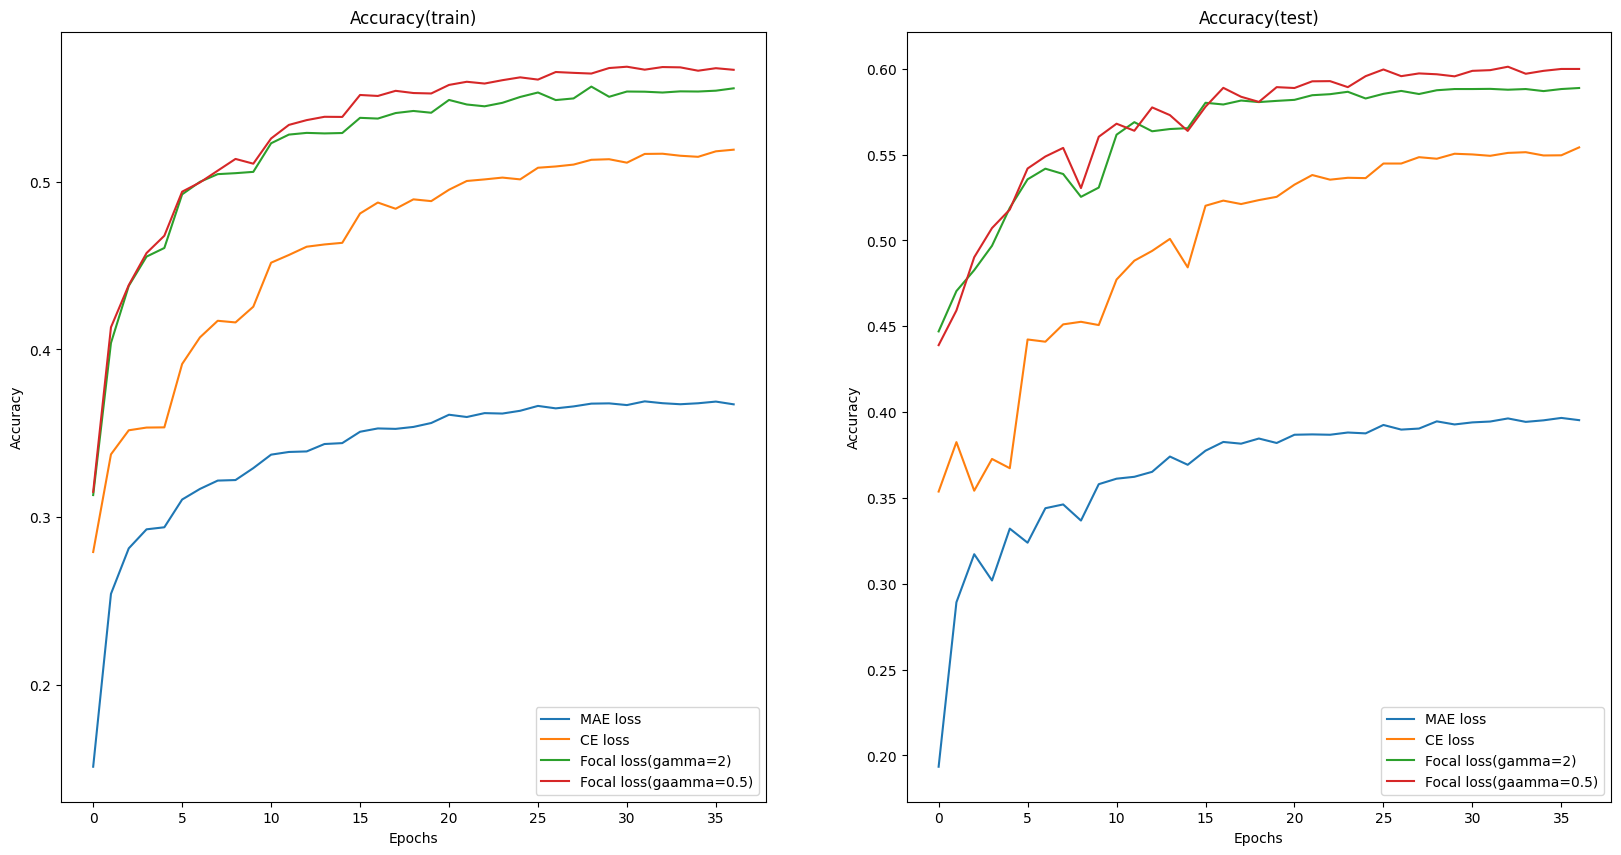

In [62]:
fig, ax = plt.subplots(1, 2,figsize=(20,10))
m = min(end_epoch_f5,end_epoch_f2,end_epoch_m,end_epoch_c)
x = np.arange(m)
ax[0].plot(x,training_acc_m[0:m], label='MAE loss')
ax[0].plot(x,training_acc_c[0:m], label='CE loss')
ax[0].plot(x,training_acc_f2[0:m], label='Focal loss(gamma=2)')
ax[0].plot(x,training_acc_f5[0:m], label='Focal loss(gaamma=0.5)')
ax[0].legend()
ax[0].set(title='Accuracy(train)', xlabel='Epochs', ylabel='Accuracy')
ax[1].plot(x,testing_acc_m[0:m], label='MAE loss')
ax[1].plot(x,testing_acc_c[0:m], label='CE loss')
ax[1].plot(x,testing_acc_f2[0:m], label='Focal loss(gamma=2)')
ax[1].plot(x,testing_acc_f5[0:m], label='Focal loss(gaamma=0.5)')
ax[1].legend()
ax[1].set(title='Accuracy(test)', xlabel='Epochs', ylabel='Accuracy')
plt.savefig("all.jpg")

### Task 2: Instance inference
---
The task is to visualizes an image along with model prediction and class probabilities.

**To do**: 
1. Calculate the prediction and the probabilities for each class.
         

In [39]:
inputs, classes = next(iter(test_dataloader))
input = inputs[0]

In [41]:
##################### Write your answer here ##################
# input: image, model
# outputs: predict_label, probabilities
# predict_label is the index (or label) of the class with the highest probability from the probabilities.
###############################################################
output = model(input.to(device))[0]
probabilities = F.softmax(output, dim=0)
predict_label = torch.argmax(probabilities)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


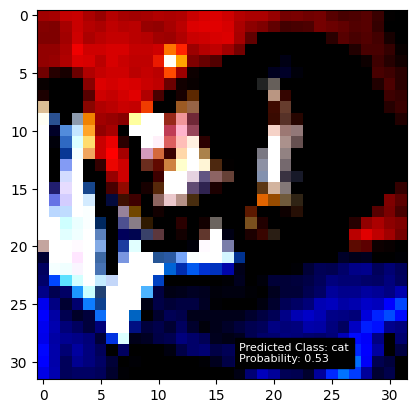

Print probabilities for each class:
airplane: 0.0040
automobile: 0.0235
bird: 0.0339
cat: 0.5311
deer: 0.0381
dog: 0.1774
frog: 0.1024
horse: 0.0367
ship: 0.0404
truck: 0.0126


In [42]:
predicted_class = class_names[predict_label.item()]
predicted_probability = probabilities[predict_label].item()
image = input.numpy().transpose((1, 2, 0))
plt.imshow(image)
plt.text(17, 30, f'Predicted Class: {predicted_class}\nProbability: {predicted_probability:.2f}', 
            color='white', backgroundcolor='black', fontsize=8)
plt.show()

# Print probabilities for each class
print('Print probabilities for each class:')
for i in range(len(class_names)):
    print(f'{class_names[i]}: {probabilities[i].item():.4f}')